# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter =';', header = 0)
# Load in the feature summary file.
feat_info =  pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter =';', header = 0 )

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

num_row = azdias.shape[0]
num_col = azdias.shape[1]

print("number of row: {}".format(num_row))
print("number of columns: {}".format(num_col))

number of row: 891221
number of columns: 85


In [4]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
type (feat_info['missing_or_unknown'])

pandas.core.series.Series

In [6]:
# build the function to get the corresponding value for missing value for each column  
def identify_missing(var): 
    missing_value_str = list(feat_info[feat_info['attribute'] == var]['missing_or_unknown'])
    #print(missing_value_str)
    missing_value_str = missing_value_str[0]
    if (len(missing_value_str) == 2):
        return []
    missing_val_list = missing_value_str[1:-1].split(',')
    result =[int(i) if i.lstrip('-+').isnumeric() else i for i in missing_val_list]
    return result 

a = identify_missing('ALTERSKATEGORIE_GROB')
print(identify_missing('AGER_TYP'))
print(a)


[-1, 0]
[-1, 0, 9]


In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
columns_list = azdias.columns.tolist()
for column in columns_list: 
    a = identify_missing(column)
    if len(a) > 0:
        for value in a:
            azdias[column] = azdias[column].replace(value, np.NaN) 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
azdias.head(n=2 )

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


Text(0,0.5,'Counts')

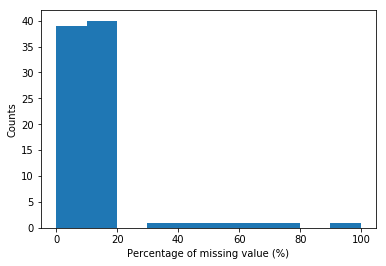

In [9]:
# Investigate patterns in the amount of missing data in each column.
missing_sum_col  = azdias.isnull().sum(axis = 0)
missing_sum_col_percentage = missing_sum_col / azdias.shape[0]*100 
plt.hist(missing_sum_col_percentage, density = False)
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Counts')

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print("number of columns before removing:  {} ".format(azdias.shape[1]))
missing_sum_col.value_counts()

# remove all columns with have number of missing value > 20% of entire sample size 
cols_remove = [col for col in azdias.columns.tolist() if (azdias[col].isnull().sum()/ azdias.shape[0] * 100 )> 20]
print(cols_remove)

azdias = azdias.drop(cols_remove, axis =1 )

print("number of columns after removing:  {} ".format(azdias.shape[1]))

azdias.shape


number of columns before removing:  85 
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
number of columns after removing:  79 


(891221, 79)

In [100]:
cols_remove

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

From the histogram of the number of missing data in each column, we can see that there are several columns have an outlier number of missing value (with the percentage of missing values greater 20% of the entire sample). Therefore, I decide to remove those columns from the original dataset. There are totally 6 columns have been removed 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

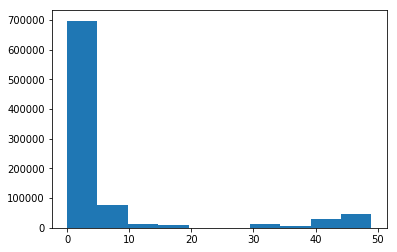

In [11]:
# How much data is missing in each row of the dataset?

missing_sum_row = azdias.isnull().sum(axis = 1)
missing_sum_row.value_counts()
plt.hist(missing_sum_row, density = False)

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias1 = azdias[missing_sum_row <10] # no or few missing values row 
azdias2 = azdias[missing_sum_row >10] # more missing values row 

print(azdias1.shape)
print(azdias2.shape)

(774743, 79)
(111068, 79)


In [13]:
azdias1.head(n=2)
azdias2.head(n=2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


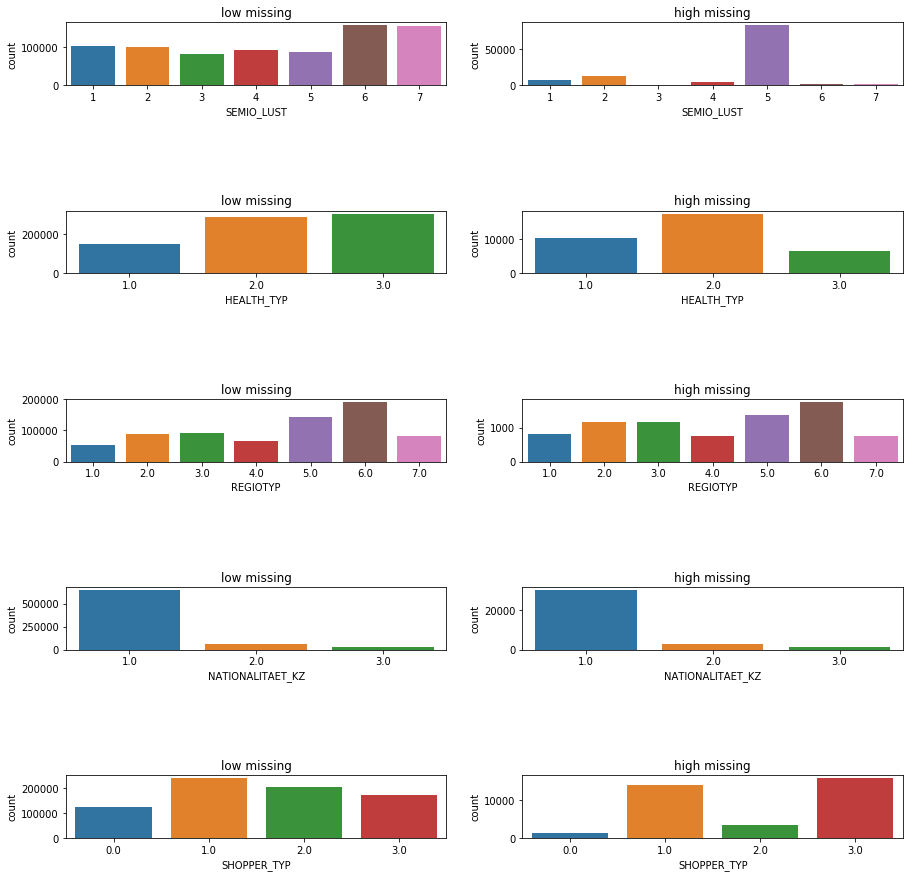

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, axes   = plt.subplots(5,2, figsize = (15, 15))
fig.subplots_adjust(hspace =2 , wspace=.2)

columns_plot = ['SEMIO_LUST','HEALTH_TYP', 'REGIOTYP', 'NATIONALITAET_KZ','SHOPPER_TYP']
for i, col in enumerate(columns_plot):
    sns.countplot(azdias1[col], ax = axes[i,0])
    axes[i,0].set_title('low missing')
    sns.countplot(azdias2[col], ax = axes[i,1])
    axes[i,1].set_title('high missing')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)
There are two ways to deal with missing value: 
*  Drop all the row with any missing value. 
However, this way leads to a significant reduction in sample size.  
*  Drop only the rows with a large number of missing value, then do the imputation for the missing value. 

I decide to keep the all the rows with number of missing value in that row <10, and saved in the dataset azdias1, this data set represents about 85% number of samples from the original dataset 

From the countplot graph above for five columns from two datasets, we can see that the dataset with few or no missing values (azdias1) and the dataset with many missing values (azdias2) do not have the similar distribution for some variables such as 'SEMIO_LUST', 'HEALTH_TYP', 'SHOPPER_TYP'. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [15]:
# How many features are there of each data type?
feat_info['type'].value_counts().index.tolist()

['ordinal', 'categorical', 'mixed', 'numeric', 'interval']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [16]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# list of categorial columns 
categorical = feat_info[(feat_info['type'] == 'categorical')]['attribute']
categorical_list = list(categorical)
print("list of categorical variables:  {}".format(categorical_list))

# list of mixed type variable 
mixed = feat_info[(feat_info['type'] == 'mixed')]['attribute']
mixed_list = list(mixed)
print("list of mixed variables:  {}".format(mixed_list))


list of categorical variables:  ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
list of mixed variables:  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [17]:
# remove categorical columns which  have redundant information: 
categorical_remove = ['LP_FAMILIE_FEIN', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'LP_STATUS_FEIN', 'GEBAEUDETYP']
azdias1 = azdias1.drop(categorical_remove, axis = 1)

#Label encode the categorical variable that takes non-numeric values:  OST_WEST_KZ'
map_binary ={'W': 0, 'O': 1}
azdias1['OST_WEST_KZ'] = azdias1['OST_WEST_KZ'].map(map_binary)


In [18]:
azdias1.shape

(774743, 74)

In [19]:
import pandas as pd 
# impute the missing value using the mode value of that feature
columns = azdias1.columns.tolist()
from sklearn.preprocessing import Imputer
Imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis = 0)
azdias1= Imputer.fit_transform(azdias1)
azdias1  = pd.DataFrame(azdias1, columns = columns )
azdias1.head(n=5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [20]:
# to do one-hotEncode categorical variable(s) which have more than 2 category 
columns = azdias1.columns.tolist()
multi_list = []
for col in columns: 
    if col in categorical_list and len(azdias1[col].unique()) >2:  # get only the categorical columns which is non-binary 
        multi_list.append(col)
        
# One Hot Encode those variables 
azdias1_encoded= pd.get_dummies(data= azdias1, columns = multi_list)


In [21]:
multi_list
azdias1_encoded.shape

(774743, 113)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I drop the following columns since the information of those features are redundant, that we can find from other columns:
*  LP_FAMILIE_FEIN: fine family-style scale. I drop this variable, and I use the variable LP_FAMILIE_GROB contain the rough scale of the same characteristics. 
* CAMEO_DEUG_2015: wealth/life stage rough scale.  The information of wealth/life stage can be obtained from CAMEO_INTL_2015
* CAMEO_DEU_2015: wealth/life stage fine scale. The information of wealth/life stage can be obtained from CAMEO_INTL_2015
* LP_STATUS_FEIN: status fine scale. I drop this variable and use LP_STATUS_GROB with a rough scale of the same characteristics.  
* GEBAEUDETYP: in the customer file(used later in step 3),  this columns does not have the same set of unique value (5-- doesn't appear in this columns in customer file) like the azdias file, that makes the number of columns after using pd.get_dummies to One-Hot-Encode the customers data is  less than the azdias data frame after One-Hot-Encode. It will be problematic when I transform the customer data using PCA model. Therefore I decide to remove this variable to make things easier 

After removing those columns,  I do One Hot Encode for all the non-binary categorical variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def decades(x):
    if x in [1,2]: 
        return 40 
    elif x in [3,4]:
        return 50 
    elif x in [5, 6, 7]:
        return 60
    elif x in [8,9]:
        return 70 
    elif x in [10, 11, 12, 13]:
        return 80 
    elif x in [14, 15]:
        return 90 
    else:
        return np.NaN

def Mainstream(x):
    if x in [1,3, 5, 8, 10, 12, 14]: 
        return 1  
    else:
        return 0
    
#azdias1['PRAEGENDE_JUGENDJAHRE'].value_counts()
azdias1_encoded['decades'] = azdias1_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: decades(x))
azdias1_encoded['mainstream'] = azdias1_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: Mainstream(x))

In [24]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def wealth(x):
    if x == np.NaN: 
        return np.NaN
    else:
        return int(x)//10
    
def life_stage(x):
     if x == np.NaN: 
        return np.NaN
     else:
        return int(x)%10
    
    
azdias1_encoded['wealth'] = azdias1_encoded['CAMEO_INTL_2015'].apply(lambda x: wealth(x))
azdias1_encoded['life_stage'] = azdias1_encoded['CAMEO_INTL_2015'].apply(lambda x: life_stage(x))

In [25]:
azdias1_encoded.head(n=2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,decades,mainstream,wealth,life_stage
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,1,0,90,1,5,1
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,1,0,90,0,2,4


In [26]:
# Remove mixed categorical variables after engineering 
mixed_remove1 = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'] 
azdias1_encoded = azdias1_encoded.drop(mixed_remove1, axis=1)

In [27]:
# Remove the rest of mixed features 
mixed_remove2 =  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
azdias1_encoded = azdias1_encoded.drop(mixed_remove2, axis = 1)

In [28]:
azdias1_encoded.head(n=5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,decades,mainstream,wealth,life_stage
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,1,0,90,1,5,1
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,1,0,90,0,2,4
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0,0,1,0,0,0,70,1,1,2
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,1,0,0,70,1,4,3
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,1,0,0,50,1,5,4


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The mixed-Type Features that I engineer include: 
* PRAEGENDE_JUGENDJAHRE
* CAMEO_INTL_2015

The mixed features I drop include: 

*  LP_LEBENSPHASE_FEIN ->life stage information which is available in 'life_stage' feature
*  LP_LEBENSPHASE_GROB -> life stage information which is available in 'life_stage' feature
*  WOHNLAGE: neighborhood quality information which is similar to REGIOTYP feature 
*  KBA05_BAUMAX (This column is already dropped in step 1.1 due to a significant amount of missing samples) 
*  PLZ8_BAUMAX - have information that is available in PLZ8_ANTG1 - PLZ8_ANTG4 features 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [53]:
def clean_data(df): 
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    columns = df.columns.tolist()
    for col in columns: 
        a = identify_missing(col)
        if len(a)>0:
            for val in a: 
                df[col] = df[col].replace(val, np.NaN)
   
    # remove selected columns and rows, ...
    
    # 1. remove all columns with number of missing values >20% of sample size 
    df = df.drop(cols_remove, axis =1 )
    
    # 2. remove rows with significant amount of missing value 
    missing_sum_row  = df.isnull().sum(axis  = 1)
    df1 = df[missing_sum_row < 10 ]
    df2 = df[missing_sum_row >=10 ]
    
    # select, re-encode, and engineer column values.
    # 3. remove columns with redundant information  
    df1 = df1.drop(categorical_remove , axis = 1 )
    #re-encode one nonmumeric categorical variable  OST_WEST_KZ
    df1['OST_WEST_KZ'] = df1['OST_WEST_KZ'].map(map_binary)
    
    # impute the missing value 
    from sklearn.preprocessing import Imputer
    columns = df1.columns.tolist()
    Imp = Imputer(missing_values='NaN', strategy='most_frequent', axis = 0)
    df1 = Imp.fit_transform(df1)
    df1  = pd.DataFrame(df1, columns = columns )
    
    # reencode multi-categorical variables (the list of those variables is  reencode_list)
    df1_encoded = pd.get_dummies(data = df1, columns = multi_list )
    
    #engieer mixed type data  
    df1_encoded['decades'] = df1_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: decades(x))
    df1_encoded['mainstream'] = df1_encoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: Mainstream(x))
    df1_encoded['wealth'] = df1_encoded['CAMEO_INTL_2015'].apply(lambda x: wealth(x))
    df1_encoded['life_stage'] = df1_encoded['CAMEO_INTL_2015'].apply(lambda x: life_stage(x))
    #drop the original mixed type data 
    df1_encoded = df1_encoded.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis =1 )
    #drop the rest of mixed type data 
    df1_encoded = df1_encoded.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX' , 'WOHNLAGE'], axis = 1 )
    
    
    
    return df1_encoded, df1 

    # Return the cleaned dataframe.
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
column_names = azdias1_encoded.columns.tolist()
scaler = StandardScaler()
scaler.fit(azdias1_encoded)
azdias_scaled = scaler.transform(azdias1_encoded)
azdias_cleaned = pd.DataFrame(data = azdias_scaled , columns = column_names )


In [33]:
azdias_cleaned.shape

(774743, 111)

### Discussion 2.1: Apply Feature Scaling

I imputed few missing values in rows replacing them with the most frequent value. I used the StandardScale to normalize the values before applying PCA and Cluster. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [34]:
# Apply PCA to the data.
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(azdias_cleaned)
print(pca.explained_variance_ratio_)  


[  1.15893061e-01   9.32645020e-02   5.97133540e-02   3.81145833e-02
   2.75823103e-02   2.12044575e-02   1.93593820e-02   1.91458191e-02
   1.76849659e-02   1.68161055e-02   1.57012876e-02   1.52027283e-02
   1.51065543e-02   1.40781114e-02   1.32699365e-02   1.28484129e-02
   1.22459390e-02   1.21876546e-02   1.18858073e-02   1.16898053e-02
   1.12532302e-02   1.09943652e-02   1.09312435e-02   1.06887735e-02
   1.03713232e-02   1.02361559e-02   1.00910390e-02   9.99954285e-03
   9.96273398e-03   9.89030419e-03   9.71396888e-03   9.62932894e-03
   9.46787209e-03   9.42913451e-03   9.37374608e-03   9.24996609e-03
   9.15161015e-03   9.09547680e-03   9.05009892e-03   8.98472718e-03
   8.83777749e-03   8.71038700e-03   8.60020787e-03   8.48640921e-03
   8.31311114e-03   8.15533263e-03   7.62935189e-03   7.52269946e-03
   7.46743470e-03   7.20848152e-03   7.10199264e-03   7.00600474e-03
   6.88464799e-03   6.58961819e-03   6.43489924e-03   6.19681244e-03
   6.04526012e-03   5.66587133e-03

In [35]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca): 
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    values  = pca.explained_variance_ratio_
    values_accum = np.cumsum(values)
    print(values_accum[60])
    fig = plt.figure(figsize = (10, 6))
    plt.subplot(111)
    plt.plot(ind, values_accum )
    plt.bar( ind,  values)
    plt.xlabel("Principal Components ")
    plt.ylabel("% explained variance ")
    plt.title('Explained Variance Per Principal Component')


In [36]:
print(len(pca.explained_variance_ratio_))
print(azdias_cleaned.shape[1])

111
111


0.908743363067


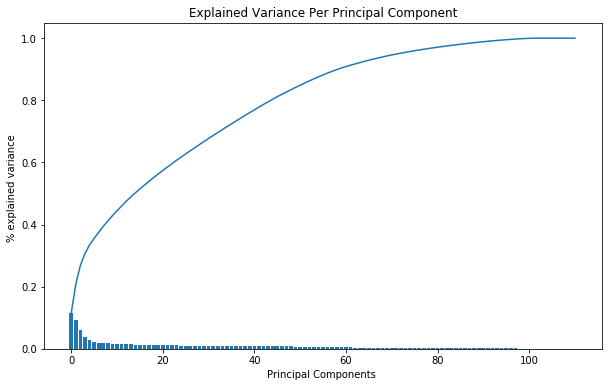

In [37]:
scree_plot(pca)

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 60 )
pca.fit(azdias_cleaned)
print(pca.explained_variance_ratio_)  
azdias_pca = pca.transform(azdias_cleaned) 
pca_components = pca.components_ 

azdias_pca.shape

[ 0.11589306  0.0932645   0.05971335  0.03811458  0.02758231  0.02120446
  0.01935938  0.01914582  0.01768496  0.0168161   0.01570128  0.01520267
  0.01510654  0.01407811  0.01326986  0.01284839  0.01224587  0.0121876
  0.01188573  0.01168968  0.01125304  0.0109943   0.01093098  0.01068838
  0.01037104  0.01023596  0.01009082  0.00999947  0.00996113  0.00988952
  0.00971241  0.00962862  0.00946725  0.00942907  0.00937296  0.00924952
  0.00915126  0.00909532  0.00904961  0.00898431  0.0088371   0.0087059
  0.00859899  0.00848445  0.00831007  0.00815185  0.00762824  0.00752027
  0.00746558  0.00720231  0.00710167  0.00700381  0.00687604  0.00658134
  0.00643352  0.00619028  0.00603392  0.00565515  0.00541696  0.00515657]


(774743, 60)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

From the Figure above, we can see that 60 principal components (in total 111 components)  can explained for about more than 91% variance in the dataset. We reduce the dimension nearly 50% but still can have more than 90% variance in the original data set. So I choose 60 principal components to re-do the PCA.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
import operator 
def map_weight(i): 
    features = azdias_cleaned.columns.tolist()
    weights = {}
    for j, feature in enumerate(features):
        weight = pca.components_[i][j]
        weights[feature] = weight
    weights_list = sorted(weights.items(), key = operator.itemgetter(1), reverse = True)
    
    return weights_list 
    

In [40]:
# weight for the first component 
import pprint 
weights_1 = map_weight(1)
pprint.pprint(weights_1)

[('ALTERSKATEGORIE_GROB', 0.20848205519842608),
 ('ZABEOTYP_3.0', 0.19944197100385327),
 ('FINANZ_VORSORGER', 0.1935060899549528),
 ('SEMIO_ERL', 0.1795810074298477),
 ('RETOURTYP_BK_S', 0.14994181485851549),
 ('SEMIO_LUST', 0.14771508223959232),
 ('FINANZ_HAUSBAUER', 0.13637184840793737),
 ('W_KEIT_KIND_HH', 0.12761412574721212),
 ('PLZ8_ANTG3', 0.12257476297185563),
 ('PLZ8_ANTG4', 0.11615752864329089),
 ('EWDICHTE', 0.11213454254210345),
 ('ORTSGR_KLS9', 0.11164736219956214),
 ('wealth', 0.10573248273554867),
 ('CJT_GESAMTTYP_2.0', 0.096873285070322002),
 ('FINANZTYP_5.0', 0.09369488747109174),
 ('SEMIO_KRIT', 0.093528933500674954),
 ('HH_EINKOMMEN_SCORE', 0.092359258123545007),
 ('KBA05_ANTG4', 0.090595558714466798),
 ('SEMIO_KAEM', 0.088985804109447106),
 ('PLZ8_ANTG2', 0.084483951860801515),
 ('ARBEIT', 0.084344707615842562),
 ('LP_FAMILIE_GROB_1.0', 0.083588726680106473),
 ('ANZ_HAUSHALTE_AKTIV', 0.080427578263693178),
 ('RELAT_AB', 0.079765104221900821),
 ('LP_STATUS_GROB_1.0',

In [41]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_2 = map_weight(2)
pprint.pprint(weights_2)

[('SEMIO_VERT', 0.32483191623706265),
 ('SEMIO_SOZ', 0.25840921385988408),
 ('SEMIO_FAM', 0.25774222024803894),
 ('SEMIO_KULT', 0.24464830740434138),
 ('FINANZTYP_5.0', 0.14258995320401241),
 ('FINANZ_MINIMALIST', 0.12764591739521852),
 ('SHOPPER_TYP_0.0', 0.12649708538678009),
 ('ZABEOTYP_1.0', 0.10409042067643247),
 ('SEMIO_REL', 0.10147545149943056),
 ('RETOURTYP_BK_S', 0.090174812383336092),
 ('W_KEIT_KIND_HH', 0.079783062148431352),
 ('SEMIO_MAT', 0.078373407310239812),
 ('FINANZ_VORSORGER', 0.067680727553870612),
 ('ORTSGR_KLS9', 0.061803786338736635),
 ('EWDICHTE', 0.061723157641480689),
 ('PLZ8_ANTG3', 0.057110057340016909),
 ('PLZ8_ANTG4', 0.055875126499511554),
 ('ZABEOTYP_6.0', 0.054004826557349783),
 ('GREEN_AVANTGARDE', 0.050829744473845015),
 ('PLZ8_ANTG2', 0.040600537685028304),
 ('ARBEIT', 0.039718037413259834),
 ('RELAT_AB', 0.038797962526574262),
 ('SEMIO_LUST', 0.036630422566187031),
 ('ALTERSKATEGORIE_GROB', 0.036447337946855674),
 ('GFK_URLAUBERTYP_4.0', 0.03503314

In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_3 = map_weight(3)
pprint.pprint(weights_3)

[('GREEN_AVANTGARDE', 0.34298559673173346),
 ('LP_STATUS_GROB_5.0', 0.26767913210306205),
 ('EWDICHTE', 0.24277354830738579),
 ('ORTSGR_KLS9', 0.23369175586288587),
 ('ANZ_PERSONEN', 0.14840500776557072),
 ('ONLINE_AFFINITAET', 0.14155303693846336),
 ('SEMIO_DOM', 0.11882573389939451),
 ('LP_FAMILIE_GROB_5.0', 0.11686434451550691),
 ('FINANZTYP_5.0', 0.11628364460433148),
 ('PLZ8_ANTG3', 0.11377144971248221),
 ('ZABEOTYP_2.0', 0.10908952120594706),
 ('PLZ8_ANTG2', 0.10350583371312531),
 ('RELAT_AB', 0.1019586430079694),
 ('ZABEOTYP_1.0', 0.10042761404944804),
 ('PLZ8_ANTG4', 0.1003070143157207),
 ('SEMIO_KAEM', 0.09832028335460255),
 ('PLZ8_HHZ', 0.097936951493413305),
 ('SHOPPER_TYP_3.0', 0.068578072468283541),
 ('FINANZ_UNAUFFAELLIGER', 0.068167985668102851),
 ('ARBEIT', 0.065222886442161718),
 ('LP_STATUS_GROB_3.0', 0.062930229764439807),
 ('LP_FAMILIE_GROB_4.0', 0.06229865277253703),
 ('ANREDE_KZ', 0.061659149891811205),
 ('CJT_GESAMTTYP_6.0', 0.056643168710088149),
 ('GFK_URLAUBER

### Discussion 2.3: Interpret Principal Components

(Reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

We can interpret some relationships between negative and positive weights and positive values together or negative values together. For example, in the 1st principal component 'decade' with positive weight as opposed 'ALTERSKATEGORIE_GROB' with a negative weight. if 'decade' goes up which means becoming younger, the 
'ALTERSKATEGORIE_GROB' goes down which means getting younger. 
 

Or, in all three first principle component, these two features ('FINANZTYP_5.0', 'FINANZ_MINIMALIST'),  have positive weights and they belong to the same category as shown in the data dictionary. FINANZTYP_5.0 =1 ( or FINANZTYP = 5) means a person belongs to investor type and = 0 if he does not; while 'FINANZ_MINIMALIST' increase when a person has higher financial interest. these two variables should be positively correlated, or they should increase or decrease together.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:

from sklearn.cluster import KMeans 
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
    
def kmean_distance(data, k): 
    kmean = KMeans(n_clusters = k) 
    kmean.fit(data)
    sum_distance = kmean.inertia_ 
    return sum_distance 



In [44]:
k_values  =  [10,12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
sum_distance_list =[] 

for k in k_values: 
    sum_distance_list.append(kmean_distance(azdias_pca, k))
    

Text(0.5,1,' Sum of within cluster distance across number of clusters ')

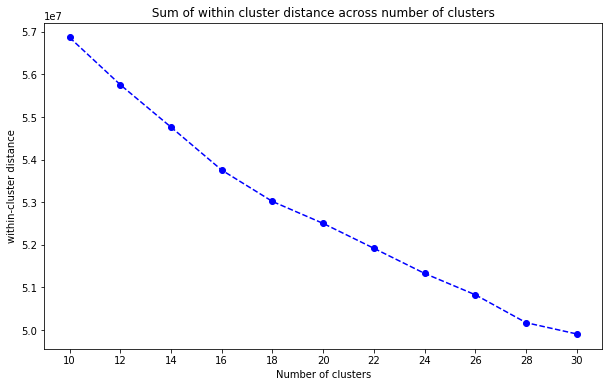

In [48]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
from matplotlib import pyplot as plt 

fig, ax  = plt.subplots(figsize = (10, 6))
ax.plot(k_values, sum_distance_list, linestyle='--', marker='o', color='b')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("within-cluster distance")
ax.set_xticks(k_values)
plt.title(" Sum of within cluster distance across number of clusters ")


In [46]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmean = KMeans(n_clusters = 18 ) 
kmean.fit(azdias_pca)
azdias_predict = kmean.predict(azdias_pca)

    

In [49]:
print(type(azdias_predict))

<class 'numpy.ndarray'>


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

From the graph plotting the within-cluster distance against the number of clusters, using elbow method we can see that at the number of cluster of 18, the rate of decrease in within cluster distance starts to reduce. Therefore, I decide to choose the number of clusters to be 18 and then re-run the KMeans clustering with that number of clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [50]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter =";" )


In [ ]:
customers.head(n=2)
customers.shape


In [54]:
customers_encoded, customers1 =  clean_data(customers)

In [55]:
customers_encoded.shape

(136159, 111)

In [57]:
# compare the clean customer data columns and the clean general data columns
azdias1_encoded.columns.difference(customers_encoded.columns)

Index([], dtype='object')

we can see that the shape of the customer data set and the general data set are not the same after preprocessing and one hot encode. The discrepany between two data is the column 'GEBAEUDETYP_5.0'.The reason for this difference is that in the customer data set, there is not sample has the value 5 for the columns GEBAEUDETYP. 

To make the customer DataFrame exactly the same as the general DataFrame to do the PCA transformation and clustering in later step, 

In [60]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data,

columns = customers_encoded.columns.tolist()
customers_scaled = scaler.transform(customers_encoded)
customers_cleaned = pd.DataFrame(customers_scaled, columns = columns )
customers_pca = pca.transform(customers_cleaned)


In [61]:
#obtaining cluster predictions for the customer demographics data.
customers_predict =  kmean.predict(customers_pca)

In [104]:
np.unique(customers_predict)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0,0.5,'Proportion of population in each cluster')

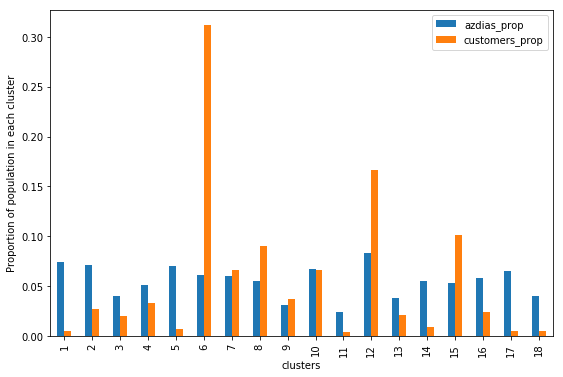

In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# create a dictionary to match the cluster number with the samples size for each cluster from the general population
from collections import Counter 
azdias_count = Counter(list(azdias_predict))                    
azdias_prop = [azdias_count[i]/len(azdias_predict)  for i in range(18)]

# create a dictionary to match the cluster number with the samples size for each cluster from  the customer population 
customers_count = Counter(list(customers_predict))          
customers_prop =[customers_count[i]/len(customers_predict) for i  in range(18)]        
# merge two part together 

azdias_customers = {'clusters' :  list(range(1, 19)), 'azdias_prop' : azdias_prop, 'customers_prop' :  customers_prop }
azdias_customers  = pd.DataFrame(azdias_customers)   


fig, ax = plt.subplots(figsize = (9, 6))
azdias_customers.plot.bar(x = 'clusters', y =['azdias_prop', 'customers_prop'], ax= ax )
ax.set_ylabel("Proportion of population in each cluster")

In [84]:
# assign the cluster result to the pre-transformed data (encoded, scaled, pca) 
# NO NEED TO USE THE INVERSE_TRANSFORM 

customers1['cluster'] = pd.Series(customers_predict)

In [85]:
# adjust to get the the cluster number range 1-18 instead of 0-17 
customers1['cluster'].value_counts()

5     42393
11    22714
14    13792
7     12314
9      9020
6      8972
8      5037
3      4469
1      3743
15     3214
12     2811
2      2767
13     1289
4      1002
17      687
16      684
0       684
10      567
Name: cluster, dtype: int64

In [92]:
customers1['cluster'] = customers1['cluster'].apply(lambda x: (x+1))

In [93]:
customers1['cluster'].value_counts()

6     42393
12    22714
15    13792
8     12314
10     9020
7      8972
9      5037
4      4469
2      3743
16     3214
13     2811
3      2767
14     1289
5      1002
18      687
17      684
1       684
11      567
Name: cluster, dtype: int64

In [94]:
# assign the cluster result to the pre-transformed data (encoded, scaled, pca)

azdias1['cluster'] = pd.Series(azdias_predict)

In [95]:
# adjust to get the the cluster number range 1-18 instead of 0-17 
azdias1['cluster'] = azdias1['cluster'].apply(lambda x: x+1)

In [102]:
# get the subset of data that are assigned to cluster number 6, which is the cluster played the most significant
# proportion in the customer data but very small proportion in the general population data  

azdias1_6  = azdias1[azdias1['cluster'] == 6] 
display(azdias1_6.head(n=5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_GROB,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,cluster
7,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,3.0,1.0,3.0,10.0,3.0,1.0,5.0,1.0,11.0,4.0,4.0,5.0,4.0,1.0,5.0,6.0,4.0,5.0,2.0,5.0,5.0,3.0,1.0,4.0,3.0,0.0,2.0,6.0,1.0,0.0,3.0,5.0,8.0,2.0,1.0,4.0,1992.0,0.0,1.0,13.0,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,6
18,3.0,1.0,3.0,5.0,3.0,3.0,2.0,2.0,1.0,6.0,12.0,1.0,3.0,20.0,5.0,2.0,5.0,2.0,9.0,5.0,4.0,5.0,4.0,1.0,5.0,1.0,4.0,6.0,2.0,5.0,5.0,3.0,5.0,4.0,0.0,0.0,2.0,4.0,2.0,0.0,4.0,3.0,2.0,1.0,0.0,3.0,1992.0,0.0,3.0,43.0,4.0,1.0,0.0,0.0,4.0,2.0,5.0,5.0,4.0,2.0,3.0,4.0,6.0,1400.0,2.0,3.0,2.0,0.0,1.0,3.0,3.0,3.0,6.0,2.0,6
30,4.0,1.0,4.0,5.0,3.0,4.0,3.0,1.0,1.0,6.0,10.0,1.0,2.0,35.0,11.0,5.0,5.0,1.0,11.0,2.0,6.0,6.0,3.0,6.0,6.0,5.0,3.0,6.0,3.0,1.0,3.0,2.0,3.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,2.0,1.0,9.0,1.0,0.0,5.0,1996.0,0.0,2.0,51.0,3.0,1.0,0.0,0.0,4.0,6.0,3.0,6.0,4.0,3.0,4.0,5.0,6.0,670.0,2.0,3.0,2.0,1.0,1.0,4.0,4.0,3.0,5.0,3.0,6
54,3.0,1.0,6.0,5.0,4.0,4.0,2.0,2.0,1.0,6.0,8.0,1.0,3.0,28.0,8.0,4.0,5.0,1.0,11.0,5.0,3.0,6.0,4.0,6.0,5.0,4.0,4.0,5.0,5.0,1.0,5.0,3.0,5.0,4.0,1.0,0.0,2.0,1.0,3.0,0.0,2.0,3.0,9.0,1.0,0.0,3.0,1992.0,0.0,2.0,22.0,1.0,2.0,1.0,0.0,3.0,3.0,5.0,5.0,4.0,2.0,4.0,5.0,2.0,990.0,2.0,3.0,2.0,0.0,1.0,3.0,3.0,2.0,5.0,3.0,6
67,3.0,1.0,2.0,4.0,2.0,3.0,2.0,2.0,1.0,6.0,10.0,1.0,1.0,39.0,12.0,5.0,5.0,1.0,11.0,4.0,3.0,2.0,4.0,6.0,5.0,4.0,4.0,5.0,5.0,3.0,5.0,3.0,3.0,4.0,1.0,0.0,2.0,1.0,4.0,0.0,3.0,2.0,9.0,2.0,0.0,4.0,1992.0,0.0,3.0,15.0,2.0,1.0,1.0,0.0,3.0,6.0,2.0,5.0,4.0,2.0,4.0,4.0,2.0,1500.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,3.0,5.0,2.0,6


In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# from the graph above cluster 6 is overrepresented in the customer data compared to the general population 
pd.options.display.max_columns = None
   
customers1_6  = customers1[customers1['cluster'] == 6] 
display(customers1_6.head(n=50))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_GROB,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,cluster
0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,4.0,1.0,1.0,20.0,5.0,2.0,5.0,1.0,4.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,3.0,0.0,1.0,3.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0.0,7.0,13.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,6
5,4.0,1.0,2.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,10.0,1.0,2.0,20.0,5.0,2.0,5.0,1.0,4.0,5.0,4.0,2.0,5.0,1.0,6.0,5.0,3.0,4.0,3.0,3.0,1.0,2.0,2.0,4.0,0.0,0.0,1.0,1.0,2.0,0.0,2.0,6.0,9.0,1.0,0.0,4.0,1992.0,0.0,7.0,23.0,4.0,1.0,0.0,0.0,4.0,6.0,2.0,5.0,4.0,2.0,4.0,4.0,3.0,1300.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0,6
6,4.0,1.0,2.0,5.0,1.0,5.0,1.0,2.0,2.0,5.0,8.0,1.0,1.0,20.0,5.0,2.0,5.0,1.0,4.0,5.0,6.0,4.0,5.0,6.0,7.0,7.0,3.0,4.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,3.0,1992.0,0.0,3.0,15.0,3.0,2.0,0.0,0.0,4.0,5.0,3.0,5.0,4.0,1.0,4.0,3.0,1.0,481.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0,6
8,3.0,1.0,3.0,5.0,2.0,4.0,1.0,3.0,1.0,2.0,1.0,1.0,3.0,28.0,8.0,4.0,5.0,1.0,9.0,2.0,6.0,4.0,4.0,1.0,7.0,4.0,4.0,5.0,2.0,3.0,5.0,3.0,3.0,4.0,0.0,0.0,2.0,1.0,3.0,0.0,1.0,2.0,9.0,1.0,0.0,5.0,1997.0,0.0,5.0,15.0,2.0,2.0,0.0,0.0,4.0,2.0,5.0,4.0,4.0,2.0,4.0,5.0,6.0,1106.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0,6
9,4.0,1.0,3.0,5.0,1.0,5.0,1.0,3.0,2.0,2.0,4.0,1.0,1.0,13.0,3.0,1.0,5.0,1.0,4.0,5.0,6.0,4.0,5.0,6.0,7.0,7.0,3.0,4.0,3.0,1.0,3.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,6.0,3.0,1.0,0.0,1.0,1992.0,0.0,4.0,14.0,4.0,0.0,0.0,0.0,5.0,6.0,2.0,6.0,3.0,1.0,4.0,5.0,1.0,623.0,4.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,5.0,1.0,6
13,3.0,1.0,3.0,5.0,1.0,5.0,1.0,1.0,2.0,5.0,5.0,1.0,1.0,40.0,12.0,5.0,5.0,1.0,6.0,3.0,6.0,5.0,4.0,6.0,7.0,6.0,4.0,5.0,5.0,3.0,2.0,3.0,3.0,4.0,1.0,0.0,2.0,1.0,5.0,0.0,1.0,2.0,9.0,1.0,0.0,4.0,1992.0,0.0,2.0,15.0,4.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,1.0,4.0,4.0,1.0,1700.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,1.0,6
14,4.0,1.0,2.0,5.0,1.0,5.0,1.0,3.0,2.0,5.0,10.0,1.0,1.0,40.0,12.0,5.0,5.0,1.0,4.0,5.0,6.0,4.0,5.0,6.0,7.0,7.0,3.0,6.0,3.0,3.0,3.0,1.0,4.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,9.0,1.0,0.0,3.0,1992.0,0.0,2.0,15.0,3.0,0.0,0.0,0.0,5.0,3.0,2.0,5.0,4.0,1.0,5.0,3.0,1.0,556.0,4.0,1.0,0.0,0.0,1.0,3.0,4.0,3.0,5.0,3.0,6
18,4.0,1.0,6.0,5.0,3.0,4.0,2.0,3.0,1.0,3.0,10.0,1.0,1.0,28.0,8.0,4.0,5.0,1.0,11.0,3.0,3.0,4.0,2.0,6.0,7.0,7.0,7.0,4.0,1.0,3.0,3.0,4.0,4.0,1.0,3.0,0.0,1.0,1.0,3.0,0.0,2.0,6.0,9.0,1.0,0.0,4.0,1994.0,0.0,2.0,33.0,3.0,0.0,0.0,0.0,4.0,2.0,5.0,2.0,4.0,3.0,5.0,5.0,7.0,410.0,4.0,1.0,0.0,0.0,1.0,3.0,4.0,4.0,6.0,5.0,6
25,3.0,1.0,3.0,5.0,2.0,3.0,1.0,2.0,1.0,5.0,11.0,1.0,1.0,36.0,12.0,5.0,3.0,1.0,9.0,5.0,3.0,5.0,4.0,6.0,7.0,6.0,4.0,6.0,5.0,1.0,5.0,3.0,3.0,4.0,1.0,0.0,2.0,1.0,5.0,0.0,2.0,2.0,9.0,1.0,0.0,1.0,1992.0,0.0,1.0,44.0,2.0,3.0,0.0,0.0,3.0,6.0,6.0,3.0,4.0,1.0,3.0,4.0,1.0,503.0,2.0,4.0,2.0,1.0,2.0,4.0,3.0,3.0,7.0,4.0,6
29,3.0,1.0,2.0,5.0,2.0,3.0,3.0,2.0,1.0,6.0,5.0,1.0,3.0,36.0,12.0,5.0,3.0,1.0,9.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,4.0,5.0,2.0,3.0,2.0,3.0,4.0,2.0,2.0,0.0,2.0,1.0,4.0,0.0,2.0,2.0,9.0,1.0,0.0,4.0,1992.0,0.0,7.0,24.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,5.0,4.0,3.0,5.0,3.0,5

In [ ]:
cols = ['FINANZTYP', 'FINANZ_ANLEGER', 'SPARER', 'FINANZTYP', 'life_stage', 'wealth', 'LP_FAMILIE_GROB',
        'LP_STATUS_GROB', ' TITEL_KZ' , 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'OST_WEST_KZ', '']

In [105]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# from the graph above cluster 1 is underrepresent in the customer data compared to the general population 

customers1_1= customers1[customers1['cluster'] == 1] 
display(customers1_1.head(n=50))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_GROB,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,cluster
787,1.0,2.0,3.0,1.0,4.0,1.0,4.0,3.0,4.0,6.0,12.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,14.0,3.0,2.0,2.0,4.0,4.0,1.0,3.0,4.0,3.0,6.0,7.0,7.0,6.0,6.0,6.0,2.0,0.0,2.0,5.0,1.0,0.0,3.0,4.0,3.0,17.0,0.0,5.0,1995.0,1.0,3.0,24.0,1.0,3.0,1.0,0.0,3.0,1.0,4.0,3.0,5.0,2.0,3.0,5.0,3.0,823.0,2.0,3.0,2.0,1.0,1.0,5.0,3.0,4.0,8.0,3.0,1
820,1.0,2.0,3.0,1.0,4.0,2.0,3.0,3.0,4.0,1.0,8.0,0.0,3.0,24.0,7.0,4.0,1.0,2.0,14.0,2.0,5.0,4.0,4.0,3.0,1.0,2.0,4.0,3.0,6.0,6.0,7.0,6.0,6.0,6.0,3.0,0.0,2.0,4.0,2.0,0.0,6.0,1.0,9.0,10.0,0.0,4.0,1992.0,0.0,3.0,54.0,0.0,2.0,3.0,0.0,3.0,2.0,5.0,1.0,3.0,2.0,2.0,5.0,2.0,738.0,1.0,4.0,2.0,1.0,5.0,4.0,3.0,2.0,5.0,3.0,1
941,1.0,2.0,3.0,1.0,3.0,2.0,5.0,3.0,5.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,15.0,2.0,2.0,4.0,5.0,3.0,1.0,3.0,2.0,3.0,6.0,7.0,7.0,6.0,6.0,6.0,2.0,0.0,2.0,5.0,1.0,0.0,4.0,6.0,9.0,4.0,0.0,1.0,1992.0,0.0,3.0,34.0,0.0,3.0,3.0,0.0,2.0,1.0,6.0,2.0,2.0,2.0,2.0,3.0,3.0,356.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,9.0,5.0,1
1072,2.0,2.0,4.0,1.0,5.0,1.0,4.0,3.0,5.0,6.0,11.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,14.0,3.0,2.0,5.0,7.0,7.0,2.0,6.0,5.0,5.0,7.0,7.0,6.0,7.0,6.0,7.0,1.0,0.0,1.0,5.0,1.0,0.0,6.0,4.0,3.0,22.0,0.0,1.0,1992.0,1.0,5.0,51.0,0.0,0.0,1.0,1.0,2.0,1.0,6.0,2.0,3.0,3.0,1.0,4.0,6.0,201.0,1.0,1.0,2.0,2.0,5.0,4.0,1.0,4.0,9.0,3.0,1
1109,2.0,2.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0,1.0,9.0,0.0,2.0,31.0,10.0,5.0,1.0,3.0,8.0,4.0,2.0,5.0,4.0,7.0,2.0,3.0,5.0,3.0,6.0,4.0,6.0,7.0,6.0,7.0,2.0,0.0,1.0,6.0,4.0,0.0,6.0,1.0,9.0,11.0,0.0,1.0,1992.0,0.0,5.0,52.0,1.0,0.0,2.0,1.0,2.0,4.0,6.0,1.0,3.0,2.0,1.0,5.0,3.0,266.0,1.0,4.0,3.0,2.0,5.0,3.0,2.0,4.0,7.0,5.0,1
1227,1.0,2.0,4.0,1.0,5.0,2.0,3.0,5.0,4.0,1.0,10.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,14.0,3.0,5.0,4.0,5.0,4.0,2.0,3.0,2.0,5.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0,0.0,2.0,5.0,1.0,0.0,6.0,4.0,3.0,20.0,0.0,1.0,1992.0,0.0,3.0,51.0,0.0,0.0,0.0,2.0,1.0,1.0,6.0,3.0,3.0,3.0,1.0,4.0,6.0,335.0,1.0,4.0,3.0,2.0,5.0,4.0,2.0,4.0,9.0,3.0,1
1501,2.0,2.0,5.0,1.0,5.0,2.0,4.0,3.0,3.0,1.0,12.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,14.0,2.0,2.0,5.0,7.0,3.0,2.0,3.0,5.0,5.0,7.0,7.0,6.0,7.0,6.0,7.0,2.0,0.0,1.0,4.0,1.0,0.0,6.0,3.0,4.0,48.0,0.0,1.0,1995.0,0.0,3.0,51.0,0.0,0.0,0.0,2.0,1.0,1.0,6.0,3.0,3.0,3.0,1.0,4.0,5.0,680.0,1.0,4.0,3.0,2.0,5.0,5.0,3.0,3.0,8.0,5.0,1
1643,1.0,2.0,4.0,1.0,4.0,2.0,2.0,5.0,3.0,1.0,11.0,0.0,3.0,1.0,1.0,1.0,1.0,1.0,14.0,2.0,5.0,4.0,5.0,4.0,1.0,2.0,2.0,3.0,6.0,6.0,7.0,6.0,6.0,6.0,3.0,0.0,2.0,5.0,1.0,0.0,6.0,4.0,6.0,12.0,0.0,1.0,1993.0,0.0,4.0,41.0,0.0,0.0,3.0,0.0,2.0,1.0,6.0,3.0,3.0,2.0,1.0,3.0,6.0,576.0,1.0,4.0,3.0,2.0,5.0,4.0,3.0,4.0,8.0,5.0,1
1645,2.0,2.0,4.0,1.0,5.0,1.0,5.0,5.0,4.0,4.0,12.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,14.0,2.0,5.0,5.0,7.0,7.0,4.0,2.0,5.0,3.0,6.0,4.0,7.0,7.0,6.0,7.0,3.0,0.0,1.0,5.0,1.0,0.0,5.0,6.0,6.0,18.0,0.0,1.0,1992.0,0.0,3.0,41.0,0.0,0.0,2.0,1.0,1.0,2.0,6.0,3.0,3.0,2.0,2.0,5.0,7.0,425.0,1.0,3.0,3.0,2.0,5.0,5.0,2.0,3.0,7.0,3.0,1
1718,2.0,2.0,4.0,1.0,4.0,2.0,3.0,3.0,4.0,1.0,11.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,14.0,3.0,5.0,5.0,4.0,3.0,2.0,6.0,5.0,2.0,6.0,7.0,7.0,7.0,5.0,7.0,3.0,0.0,2.0,4.0,1.0,0.0,5.0,4.0,6.0,13.0,0.0,1.0,1992.0,0.0,4.0,24.0,1.0,1.0,0.0,0.0,5.0,6.

From the figure displaying the relative proportion of each cluster in the customer data and general population data, we can see that the group of people in cluster 6 plays only 5% the general population but plays approximately 30% in the customer data set. Or in other words, this group is the target customer group for the mail order that the company. 
Using the original data merged with the predicted cluster results to analyze the characteristics of this group we can see that this group of people are: 
* more likely to be middle-aged male (ANREDE_KZ =1 , ALTERSKATEGORIE_GROB = 3, 4 )
* more likely to be top earner, live in wealthy household (LP_STATUS_GROB =5 , CAMEO_INTL_2015//10 = 1, 2)
* high financial interest (or very low financial minimalist, FINANZ_MINIMALIST = 4, 5)
* more likely to be money saver or investor (FINANZTYP = 2, 5)
* high-level investor (FINANZ_ANGELER = 1 ) 
* member of green avantgarde (green avantgarde =1 ) and more likely to be green energy consumption type 
* high affinity rational
* low to very low movement

In contrast, cluster 1 plays approximately 8% in general population but constitutes only less than 1% in the customers' list. So, this group is relatively unpopular in the company'customer list. 
This group are more likely to be
* more likely to be younger female (ANREDE_KZ =2,  ALTERSKATEGORIE_GROB = 1, 2)
* more likely to be low to average income earner, live in a less affluent to the poor household (LP_STATUS_GROB =1,2,3), CAMEO_INTL_2015//10 = 4, 5)
* low financial interest and inconspicuous (FINANZ_MINIMALIST = 1,2,3)
* less likely to be investor type
* low -level investor (FINANZ_ANGELER = 1 ) 
* less likely to be green avantgarde member (green avantgarde = 0) and less likely to be green energy consumption type. 
* low  affinity to very low affinity rational
* high movement 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.